In [1]:
!git clone https://github.com/gorodnitskiy/ocr_car_registration_plates.git tmp
!mv tmp/* ./.
!rm -rf tmp

Cloning into 'tmp'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 20 (delta 6), reused 19 (delta 5), pack-reused 0
Unpacking objects: 100% (20/20), done.


In [19]:
import os
import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.nn.functional import ctc_loss, log_softmax

from support_utils import freeze_seed, set_max_threads
from visualization import visualize
from crnn_model import CRNNModel, prediction_to_string, decode
from dataset import RecognitionCarPlatesDataset, Resize, \
    collate_fn, get_prepared_data, ALPHABET_MASK

### Freeze seeds and set max threads 

In [7]:
freeze_seed()
set_max_threads()

### Load data and filter them (use only "standart" civil car registration plates - that correspond to LDDDLLDD or LDDDLLDDD masks (L = "letter", D = "digit")

In [8]:
print("Default alphabet mask:", ALPHABET_MASK)
config = get_prepared_data(path='', filtering=True)
print("Total items in data after filtering:", len(config))

100%|██████████| 41141/41141 [00:00<00:00, 437794.11it/s]

Default alphabet mask: 0123456789ABEKMHOPCTYX
Total items in data after filtering: 31345


### See some sample of car plates

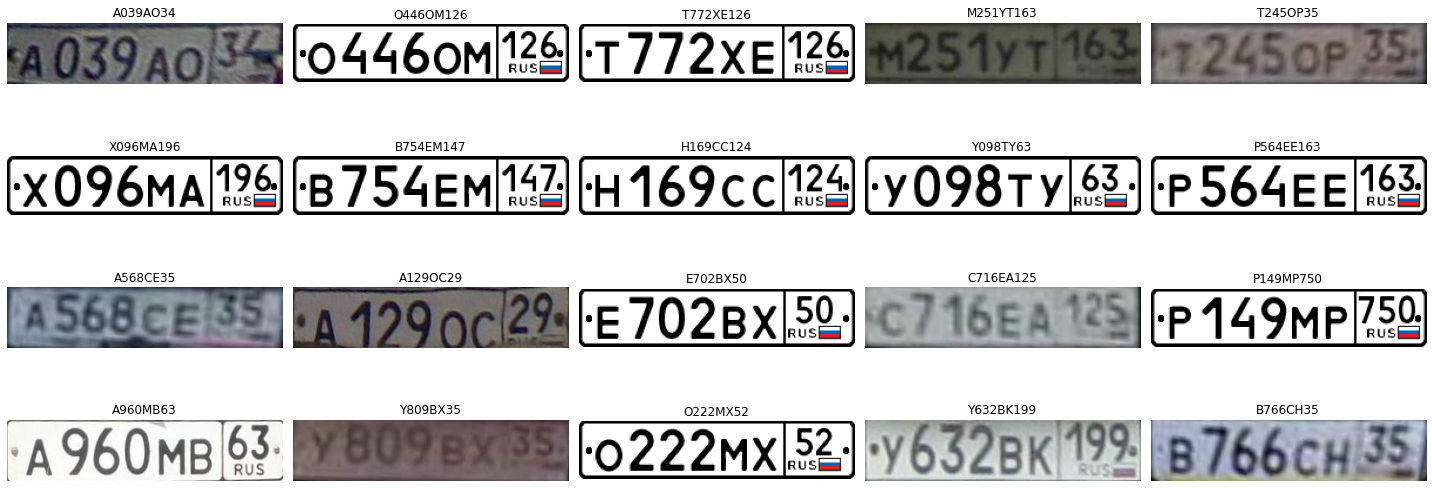

In [9]:
visualize(
    config=config,
    sample_size=20,
    num_cols=5
)

### Create Dataset (use only resize to `(320, 64)` as transformation)

In [10]:
np.random.shuffle(config)
train_size = int(len(config) * 0.8)
config_train = config[:train_size]
config_val = config[train_size:]

train_dataset = RecognitionCarPlatesDataset(config_train, transforms=Resize())
val_dataset = RecognitionCarPlatesDataset(config_val, transforms=Resize())

dict_keys(['image', 'seq', 'seq_len', 'text'])
Image shape: (64, 320, 3)
Seq: [15, 4, 7, 7, 16, 11, 3, 7] Seq_len: 8
Text: M366HA26


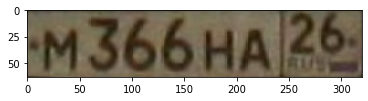

In [11]:
x = train_dataset[3000]
print(x.keys())

print("Image shape:", x["image"].shape)
print("Seq:", x["seq"], "Seq_len:", x["seq_len"])
print("Text:", x["text"])
plt.imshow(x["image"])
plt.show()

### Create dataloaders and try to train some CRNN

In [12]:
num_epochs = 10
batch_size = 128
num_workers = 4

In [13]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers, 
    pin_memory=True, 
    drop_last=True, 
    collate_fn=collate_fn)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=True, 
    drop_last=False, 
    collate_fn=collate_fn)

In [21]:
crnn = CRNNModel(model_conv='resnet18', alphabet=ALPHABET_MASK) # resnext50_32x4d

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
crnn.to(device);

In [23]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)

In [24]:
crnn.train()
for i, epoch in enumerate(range(num_epochs)):
    epoch_losses = []

    for j, b in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
        images = b["image"].to(device)
        seqs_gt = b["seq"]
        seq_lens_gt = b["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                        targets=seqs_gt,  # N, S or sum(target_lengths)
                        input_lengths=seq_lens_pred,  # N
                        target_lengths=seq_lens_gt)  # N

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    print(i, np.mean(epoch_losses))

  0%|          | 0/195 [00:00<?, ?it/s]

0 2.727414676470634


  0%|          | 0/195 [00:00<?, ?it/s]

1 0.9250212829846602


  0%|          | 0/195 [00:00<?, ?it/s]

2 0.11126757493385901


  0%|          | 0/195 [00:00<?, ?it/s]

3 0.0349561314838819


  0%|          | 0/195 [00:00<?, ?it/s]

4 0.02276010319399528


  0%|          | 0/195 [00:00<?, ?it/s]

5 0.01754302993798867


  0%|          | 0/195 [00:00<?, ?it/s]

6 0.01437117321512256


  0%|          | 0/195 [00:00<?, ?it/s]

7 0.014466717791480895


  0%|          | 0/195 [00:00<?, ?it/s]

8 0.012794448490230701


100%|██████████| 195/195 [00:24<00:00,  8.04it/s]

9 0.011358301709286677


In [25]:
crnn.eval()
val_losses = []
for i, b in enumerate(tqdm.tqdm(val_dataloader, total=len(val_dataloader))):
    images = b["image"].to(device)
    seqs_gt = b["seq"]
    seq_lens_gt = b["seq_len"]

    with torch.no_grad():
        seqs_pred = crnn(images).cpu()
    log_probs = log_softmax(seqs_pred, dim=2)
    seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

    loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                    targets=seqs_gt,  # N, S or sum(target_lengths)
                    input_lengths=seq_lens_pred,  # N
                    target_lengths=seq_lens_gt)  # N

    val_losses.append(loss.item())

print(np.mean(val_losses))

100%|██████████| 49/49 [00:02<00:00, 18.23it/s]

0.021387653677173112


### Try to see some prediction

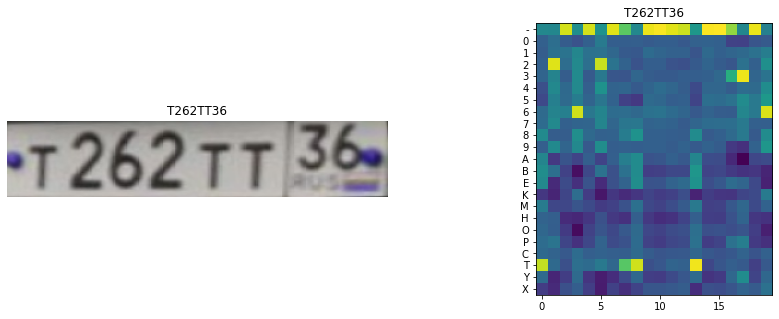

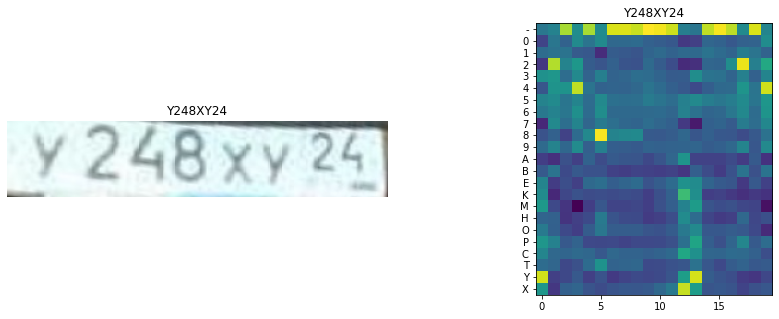

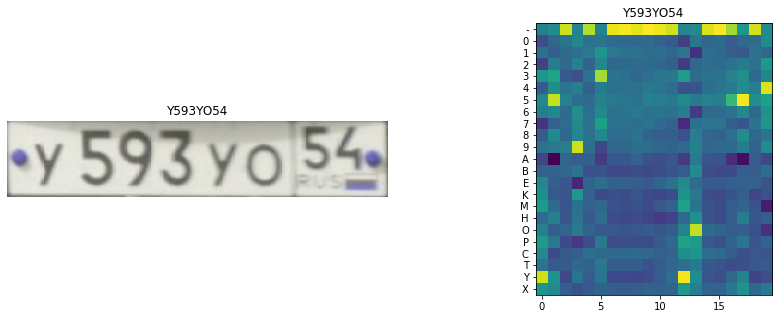

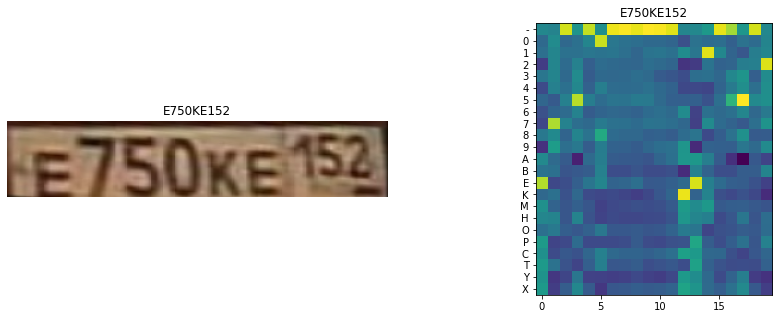

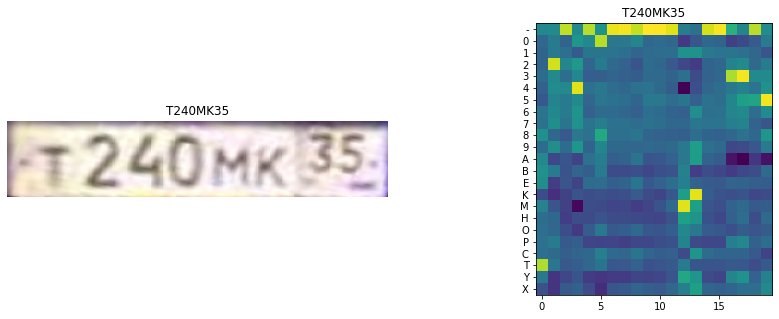

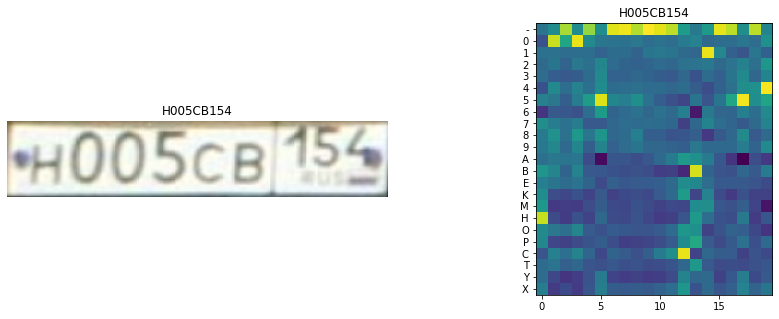

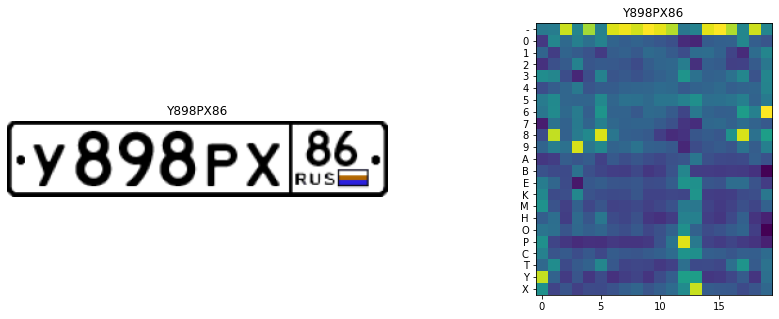

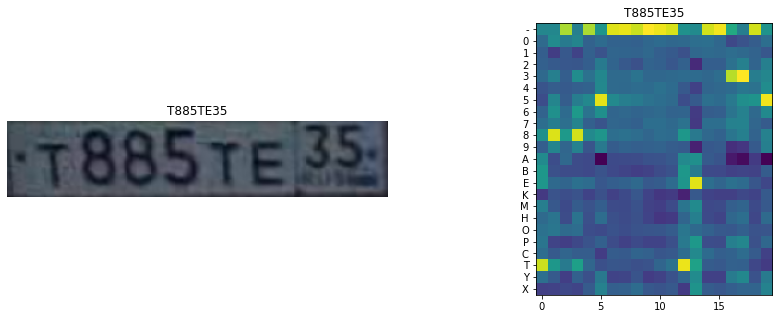

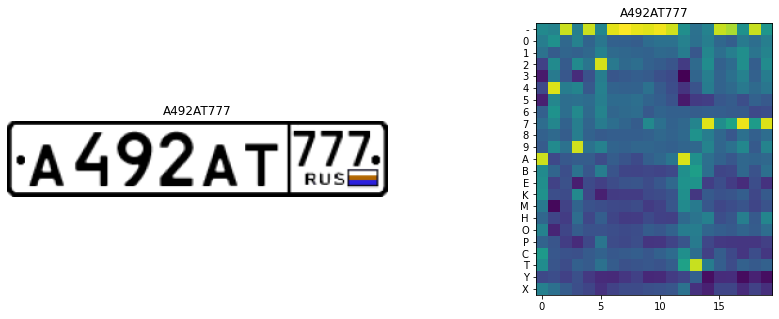

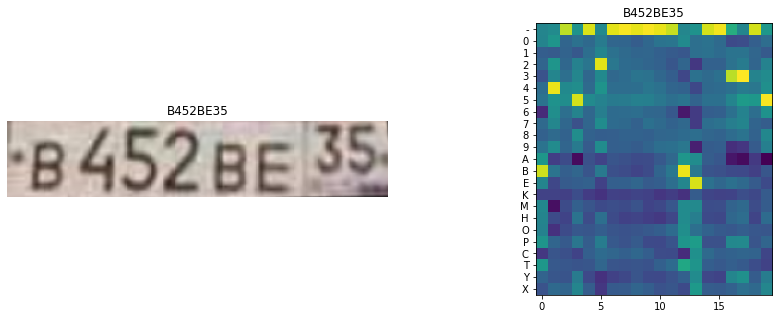

In [27]:
y_ticks = ["-"] + [x for x in crnn.alphabet]

images = b["image"]
seqs_gt = b["seq"]
seq_lens_gt = b["seq_len"]
texts = b["text"]

preds = crnn(images.to(device)).cpu().detach()
texts_pred = decode(preds, crnn.alphabet)

for i in range(10):
    plt.figure(figsize=(15, 5))
    pred_i = preds[:, i, :].T
    
    plt.subplot(1, 2, 1)
    image = images[i].permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.axis("off")
    plt.title(texts[i])
    
    plt.subplot(1, 2, 2)
    plt.yticks(range(pred_i.size(0)), y_ticks)
    plt.imshow(pred_i)
    plt.title(texts_pred[i])
    
    plt.show()